<a href="https://colab.research.google.com/github/OmicsML/dance-tutorials/blob/dev/dance_tutorial_hongzhi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch_geometric==2.3.1
!pip install dgl==1.1.0 -f https://data.dgl.ai/wheels/cu117/repo.html
!pip install torchnmf==0.3.4
!pip install git+https://github.com/OmicsML/dance.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 12.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910459 sha256=d8510362393c10299262ec6ece6b13ad0f7b0fca313f1753d52883b65aebf912
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.dgl.ai/wheels/cu117/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 MB 8.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.or

## Multi-modality tasks
- Example Tasks: Modality prediction, Modality Matching


### Modality Prediction

#### Task and Model Description

Modality Prediction: predicting the flow of information from DNA to RNA and RNA to Protein.
predict_task.svg

In this section, we take RNA-to-Protein as an example task, where the data are obtained from CITE-seq technology. We use BABEL[1] model as an example to demonstrate the workflow of DANCE package.
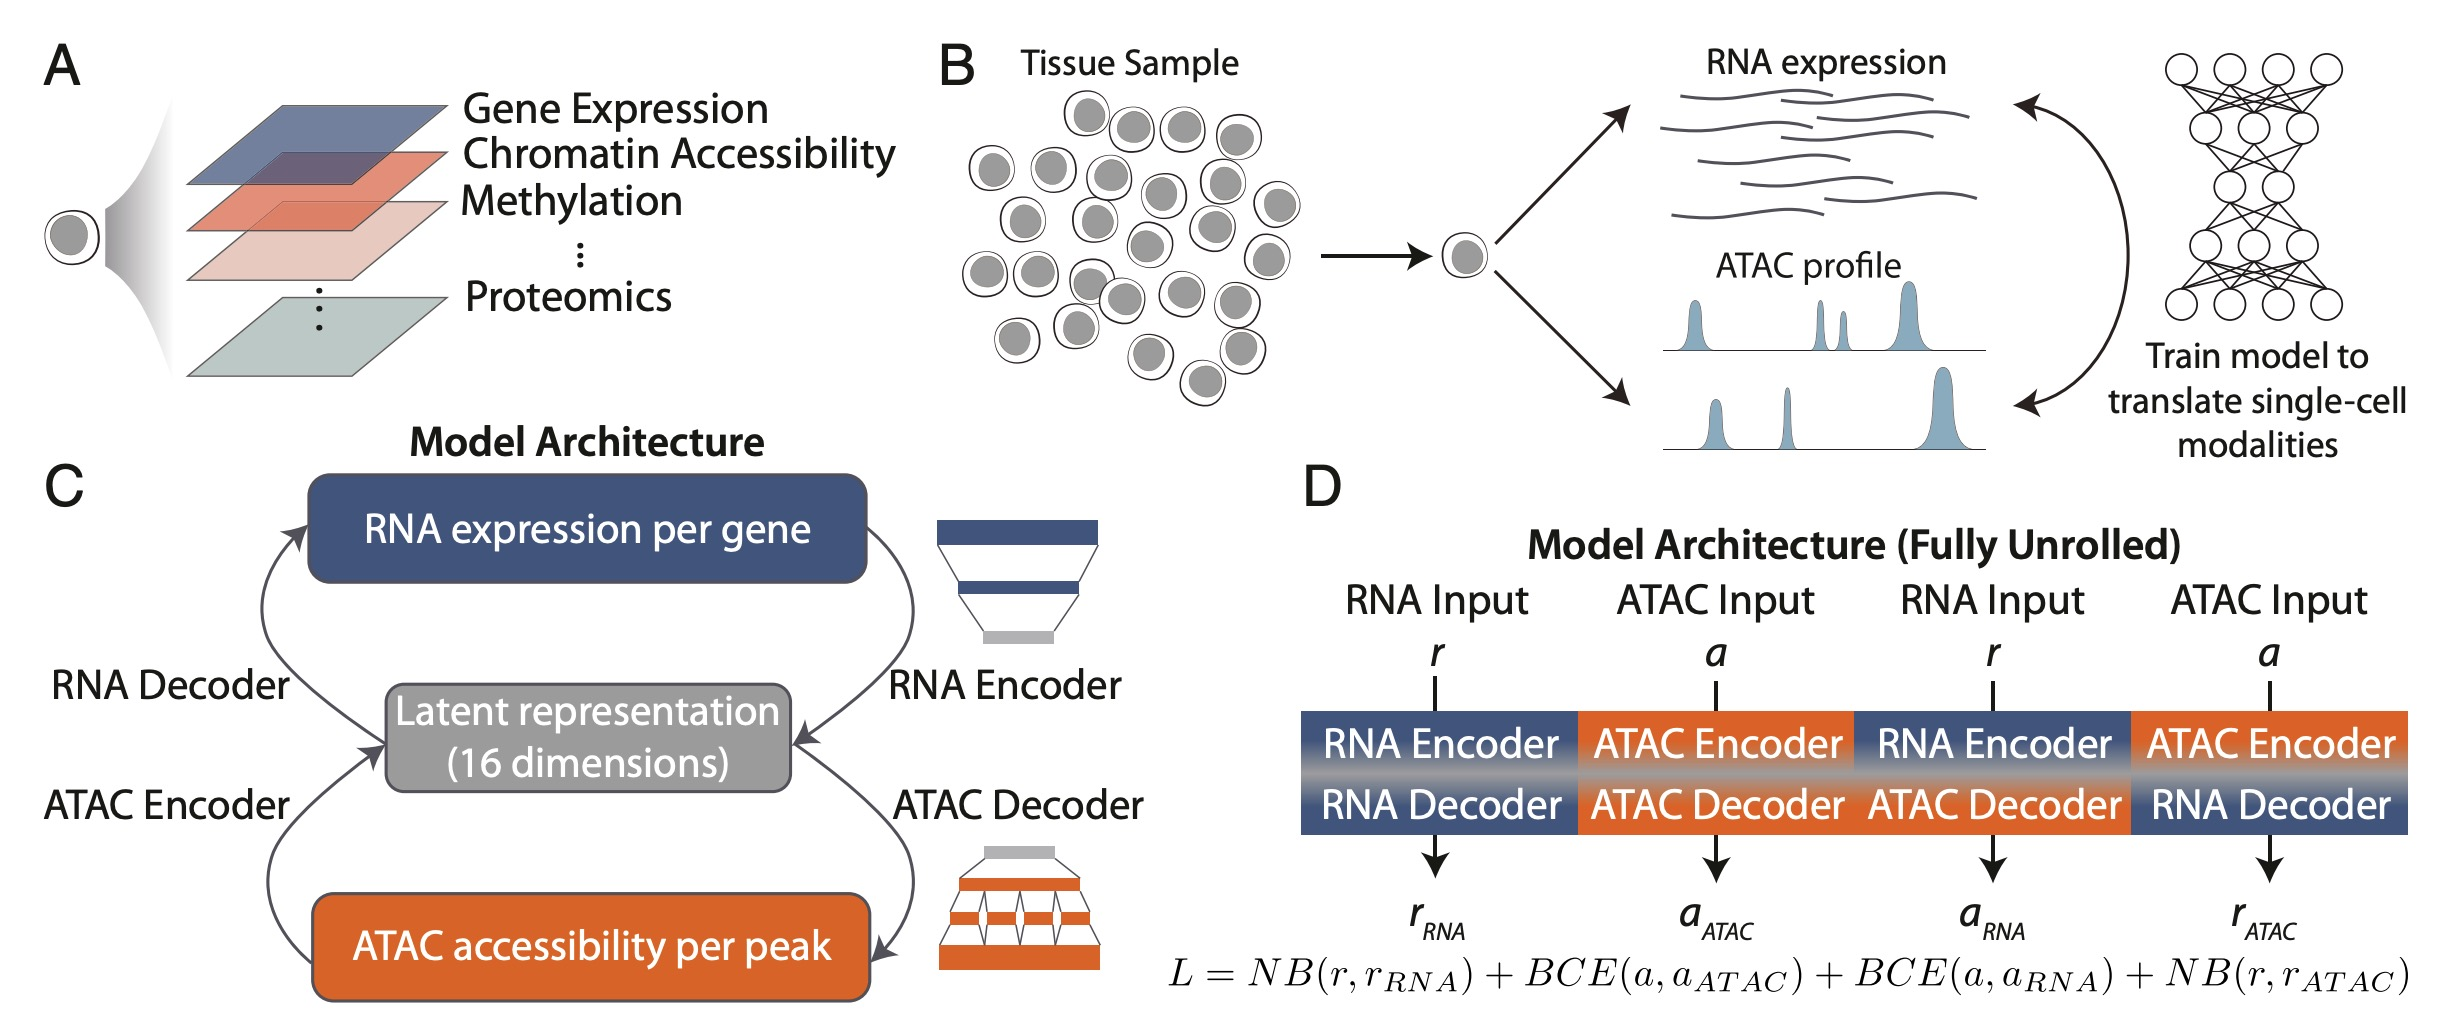

---
[1] Wu, Kevin E., et al. "BABEL enables cross-modality translation between multiomic profiles at single-cell resolution." Proceedings of the National Academy of Sciences 118.15 (2021): e2023070118.






#### Argument parsing setting

In [2]:
import anndata
import mudata
import torch
import scanpy as sc
from dance import logger
from dance.data import Data
from dance.datasets.multimodality import ModalityPredictionDataset
from dance.modules.multi_modality.predict_modality.babel import BabelWrapper
from dance.utils import set_seed
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
import argparse
import random
import torch
import os

OPTIMIZER_DICT = {
    "adam": torch.optim.Adam,
    "rmsprop": torch.optim.RMSprop,
}
rndseed = random.randint(0, 2147483647)
parser = argparse.ArgumentParser()

######## Important hyperparameters
parser.add_argument("--subtask", default="openproblems_bmmc_cite_phase2_rna")
parser.add_argument("--lossweight", type=float, default=1., help="Relative loss weight")
parser.add_argument("--lr", "-l", type=float, default=0.01, help="Learning rate")
parser.add_argument("--batchsize", "-b", type=int, default=64, help="Batch size")
parser.add_argument("--hidden", type=int, default=64, help="Hidden dimensions")
parser.add_argument("--earlystop", type=int, default=20, help="Early stopping after N epochs")
parser.add_argument("--naive", "-n", action="store_true", help="Use a naive model instead of lego model")
parser.add_argument("--max_epochs", type=int, default=500)
########

parser.add_argument("--model_folder", default="./")
parser.add_argument("--outdir", "-o", default="./", help="Directory to output to")
parser.add_argument("--resume", action="store_true")
parser.add_argument("--device", default="cuda")
parser.add_argument("--cpus", default=1, type=int)
parser.add_argument("--rnd_seed", default=rndseed, type=int)

args_defaults = parser.parse_args([])
args = argparse.Namespace(**vars(args_defaults))

rndseed = args.rnd_seed
set_seed(rndseed)
device = args.device
os.makedirs(args.model_folder, exist_ok=True)
args

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


[INFO][2023-06-25 23:45:01,804][dance][set_seed] Setting global random seed to 1480857032


Namespace(subtask='openproblems_bmmc_cite_phase2_rna', device='cuda', cpus=1, rnd_seed=1480857032, lossweight=1.0, lr=0.01, batchsize=64, hidden=64, earlystop=20, naive=False, model_folder='./', outdir='./', resume=False, max_epochs=500)

#### Load data and perform necessary preprocessing

In [3]:
dataset = ModalityPredictionDataset(args.subtask)
data = dataset.load_data()
data

[INFO][2023-06-25 23:45:02,729][dance][download_file] Downloading: /content/data/openproblems_bmmc_cite_phase2_rna.zip Bytes: 626,273,309
100%|██████████| 597M/597M [00:06<00:00, 92.7MB/s]
[INFO][2023-06-25 23:45:09,497][dance][unzip_file] Unzipping '/content/data/openproblems_bmmc_cite_phase2_rna.zip'
[INFO][2023-06-25 23:45:14,260][dance][delete_file] Deleting '/content/data/openproblems_bmmc_cite_phase2_rna.zip'
[INFO][2023-06-25 23:45:14,337][dance][_load_raw_data] Loading /content/data/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod1.h5ad
[INFO][2023-06-25 23:45:21,975][dance][_load_raw_data] Loading /content/data/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod2.h5ad
[INFO][2023-06-25 23:45:22,667][dance][_load_raw_data] Loading /content/data/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod1.h5ad
[INFO][2023-06-25 23:45:22,924][d

Data object that wraps (.data):
MuData object with n_obs × n_vars = 67175 × 14087
  uns:	'dance_config'
  2 modalities
    mod1:	67175 x 13953
      obs:	'batch', 'size_factors'
      layers:	'counts'
    mod2:	67175 x 134
      obs:	'batch', 'size_factors'
      layers:	'counts'

In [4]:
# Construct data object
data.set_config(feature_mod="mod1", label_mod="mod2")

# Obtain training and testing data
x_train, y_train = data.get_train_data(return_type="torch")

# Colab has very limited memory (12.7GB), therefore we subsample the data
x_train = x_train[:10000]
y_train = y_train[:10000]

x_test, y_test = data.get_test_data(return_type="torch")

#### Initialize model and get model specific preprocessing pipeline

In [5]:
model = BabelWrapper(args, dim_in=x_train.shape[1], dim_out=y_train.shape[1])

[INFO][2023-06-25 23:45:46,280][dance][__init__] ChromDecoder with 1 output activations


#### Train and evaluate model

In [6]:
model.fit(x_train.float(), y_train.float(), val_ratio=0.15)

epoch:  1
training (sum of 4 losses): 1.654106741561029
validation (prediction loss): 0.4043900049296053
epoch:  2
training (sum of 4 losses): 1.3850342331076027
validation (prediction loss): 0.38303264464148606
epoch:  3
training (sum of 4 losses): 1.3328260945198231
validation (prediction loss): 0.37341788327196024
epoch:  4
training (sum of 4 losses): 1.3002700312693316
validation (prediction loss): 0.36410461754839274
epoch:  5
training (sum of 4 losses): 1.2832045698524417
validation (prediction loss): 0.3583351944777575
epoch:  6
training (sum of 4 losses): 1.27145801092449
validation (prediction loss): 0.3603282897691287
epoch:  7
training (sum of 4 losses): 1.2565803169307852
validation (prediction loss): 0.35945359006499394
epoch:  8
training (sum of 4 losses): 1.247393516669596
validation (prediction loss): 0.35611722121162426
epoch:  9
training (sum of 4 losses): 1.2359575436527568
validation (prediction loss): 0.3546372997613318
epoch:  10
training (sum of 4 losses): 1.2348

In [7]:
model.predict(x_test.float())

tensor([[0.5327, 0.3459, 1.5322,  ..., 0.7448, 0.8943, 0.9886],
        [0.0000, 0.3020, 1.5863,  ..., 0.4708, 0.7639, 0.4413],
        [0.0000, 0.3319, 1.5807,  ..., 0.2495, 0.8340, 0.3733],
        ...,
        [0.0000, 0.3195, 1.1894,  ..., 0.3223, 0.4805, 0.3108],
        [0.0000, 0.3079, 1.2334,  ..., 0.3404, 0.4483, 0.2385],
        [0.0000, 0.3134, 1.5539,  ..., 0.4825, 0.7770, 0.4278]],
       device='cuda:0')

In [8]:
model.score(x_test.float(), y_test.float())

0.493180650488738